**Load Data**

In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn


# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

DAY_TIME = False
USE_MIXED = False
USE_PRESSURE_TEMP = False
USE_SPECIFIC_CLOUDS = False
LOW_VIS_FRAC = False
low_vis_frac = 0.45
low_vis_threshold = 1000 #50000
cloud_types = [6] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # fraction of max - min
dnn_batch_size = 64

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# Some data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]

if DAY_TIME:
   #data_ir_vis = data_ir_vis[np.where(np.abs(data_ir_vis[:, 33] - 90) < 30)[0]]
   data_ir_vis = data_ir_vis[np.where(data_ir_vis[:, 32] < 30)[0]]



X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test_reg = train_test_split(X_scaled, y_scaled, test_size=(1/20))


if LOW_VIS_FRAC:
    low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
    high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]

    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
    y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])


# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train_reg, y_val_reg = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_class = np.where(target_scaler.inverse_transform(y_train_reg) < low_vis_threshold, 1, 0)
y_val_class = np.where(target_scaler.inverse_transform(y_val_reg) < low_vis_threshold, 1, 0)
y_test_class = np.where(target_scaler.inverse_transform(y_test_reg) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_reg)).batch(batch_size=dnn_batch_size)
training_data_class = tf.data.Dataset.from_tensor_slices((X_train, y_train_class)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_class = training_data_class.map(noise_map)

**Classification All Clouds**

XGBoost (Gradient boosted decision trees)

              precision    recall  f1-score   support

           0       0.97      0.78      0.86     20451
           1       0.26      0.77      0.39      2048

    accuracy                           0.78     22499
   macro avg       0.62      0.78      0.63     22499
weighted avg       0.91      0.78      0.82     22499



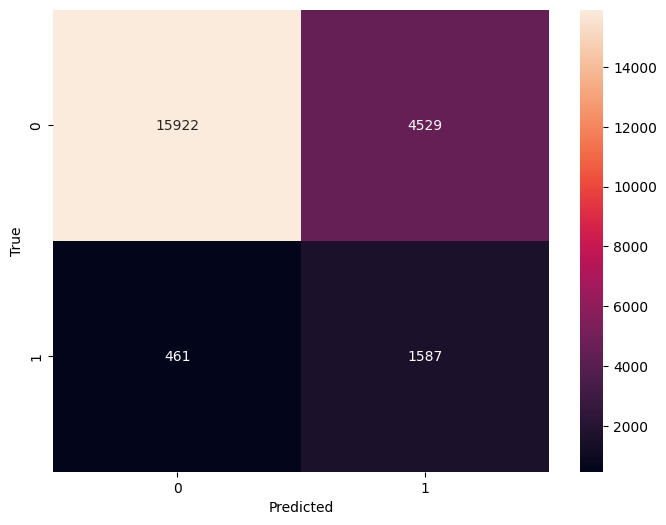

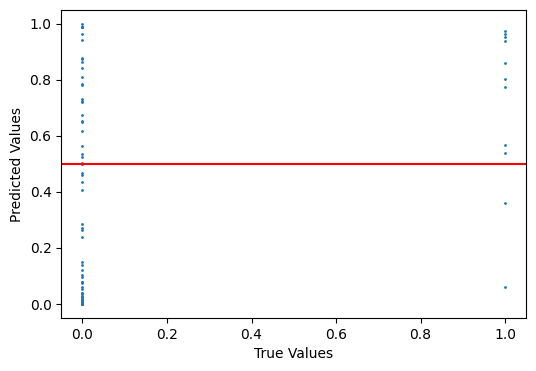

In [8]:
import xgboost as xgb

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_class)

params = {
    'objective': 'binary:logistic',  
    'max_depth': 20,
    'learning_rate': 0.05,
    #'scale_pos_weight': neg_to_pos_ratio,

}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
y_pred = model.predict(dtest)
y_pred_class = (y_pred > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_class[:100], y_pred[:100], s=1)
plt.axhline(y=0.5, color='r', linestyle='-') 
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

Deep Neural Network

704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


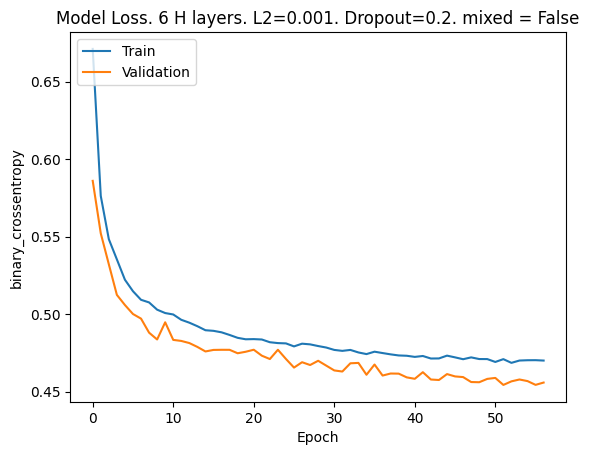

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     20451
           1       0.25      0.84      0.39      2048

    accuracy                           0.76     22499
   macro avg       0.62      0.80      0.62     22499
weighted avg       0.91      0.76      0.81     22499



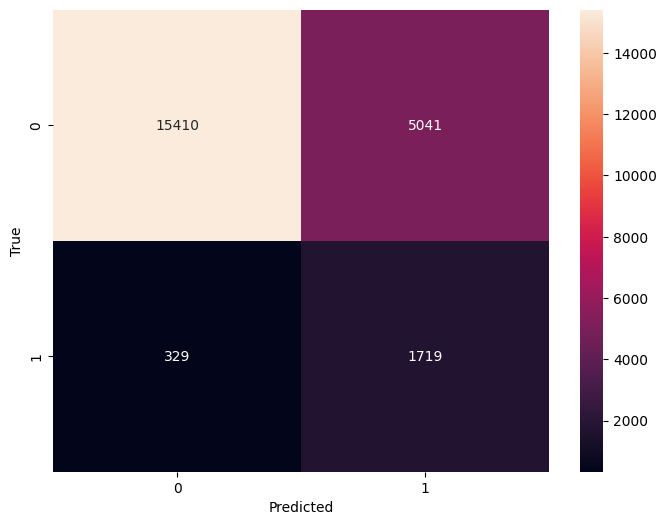

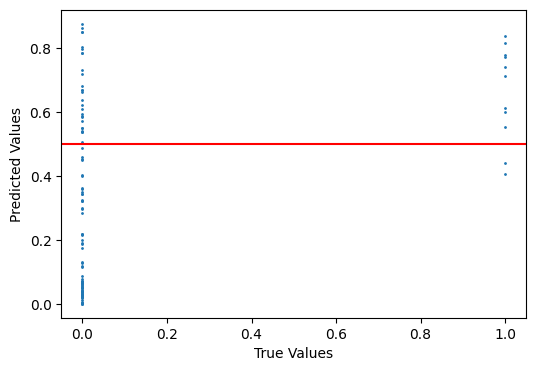

In [12]:
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.losses import BinaryFocalCrossentropy


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 #loss = BinaryFocalCrossentropy(alpha=0.50, gamma=2, apply_class_balancing=False),
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = ff_model.fit(training_data_class, epochs = 100, validation_data=(X_val_noisy, y_val_class), verbose=0, callbacks=[early_stopping])


y_pred = ff_model.predict(X_test)

y_pred_class = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_class)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_class))
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_class[:100], y_pred[:100], s=1)
plt.axhline(y=0.5, color='r', linestyle='-') 
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

**Classification on single cloud type (only cirrus clouds, clear data not included!)**

XGBoost

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      6566
           1       0.41      0.82      0.55       933

    accuracy                           0.83      7499
   macro avg       0.69      0.83      0.72      7499
weighted avg       0.90      0.83      0.85      7499



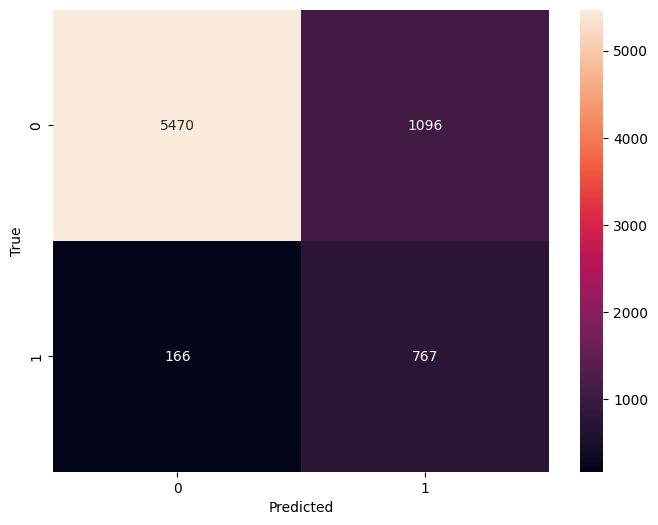

In [20]:
import xgboost as xgb

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_class)

params = {
    'objective': 'binary:logistic',  
    'max_depth': 16,
    'learning_rate': 0.05,
    #'scale_pos_weight': neg_to_pos_ratio,

}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
predictions_1 = model.predict(dtest)
y_pred_class = (predictions_1 > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Deep Neural Network

/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1711118272.485713 1364871 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


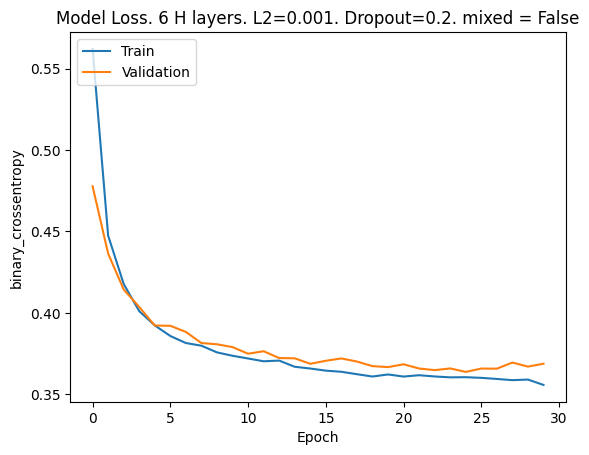

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      6566
           1       0.49      0.77      0.60       933

    accuracy                           0.87      7499
   macro avg       0.73      0.83      0.76      7499
weighted avg       0.91      0.87      0.88      7499



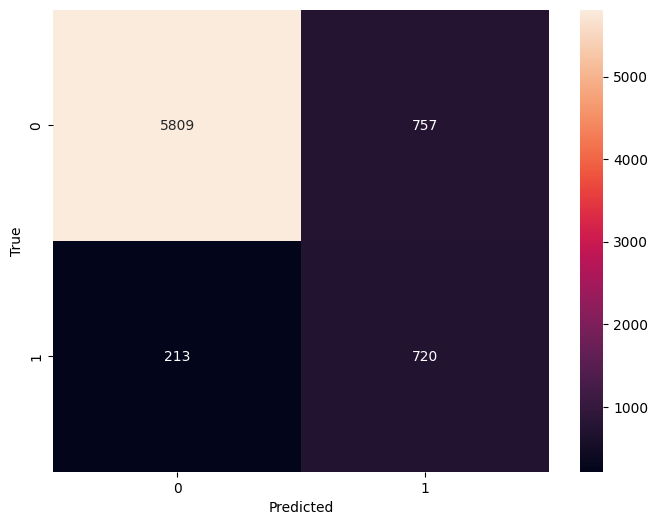

In [21]:
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.losses import BinaryFocalCrossentropy


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 #loss = BinaryFocalCrossentropy(alpha=0.50, gamma=2, apply_class_balancing=False),
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = ff_model.fit(training_data_class, epochs = 100, validation_data=(X_val_noisy, y_val_class), verbose=0, callbacks=[early_stopping])


y_pred = ff_model.predict(X_test)

y_pred_class = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_class)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_class))
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Regression models on all cloud types**

XGBoost

MSE: 0.7012953162193298


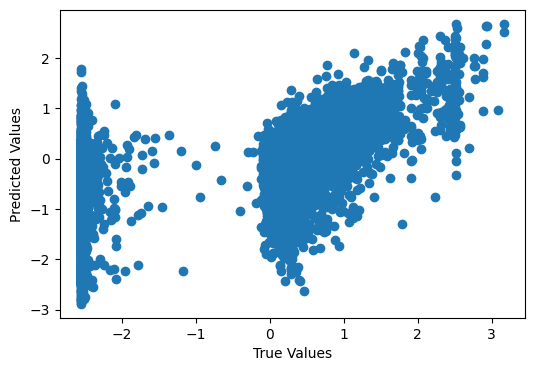

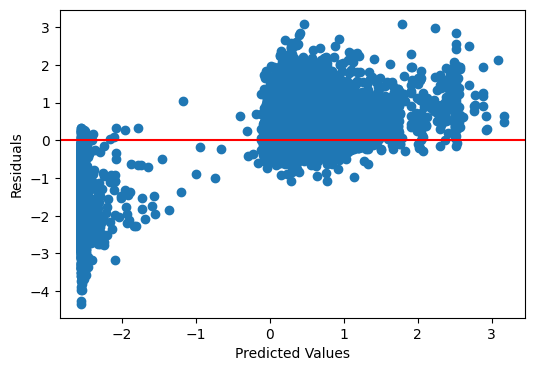

In [31]:
import xgboost as xgb
from sklearn.metrics import classification_report

#neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)


dtrain = xgb.DMatrix(X_train_noisy, label=y_train_reg)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_reg)

params = {
    'objective': 'reg:squarederror',  # For regression
    'max_depth': 16,  # Maximum tree depth
    'learning_rate': 0.05,
    'subsample': 0.8,
    #'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
y_pred_reg = model.predict(dtest)
residuals = y_test_reg.ravel() - y_pred_reg


print(f'MSE: {mean_squared_error(y_test_reg.ravel(), y_pred_reg)}')

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Deep Neural Network

/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean squared error: 0.7137416005134583


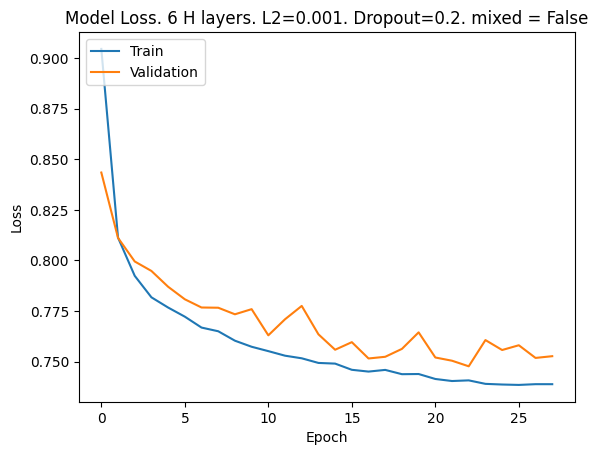

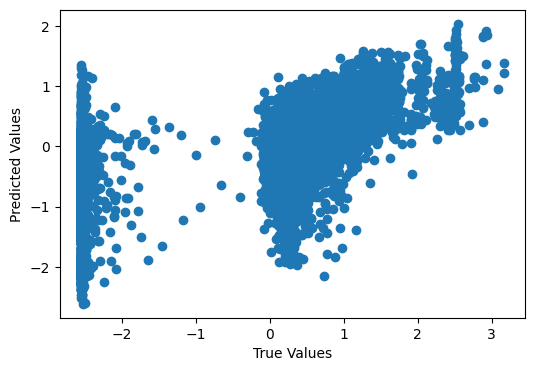

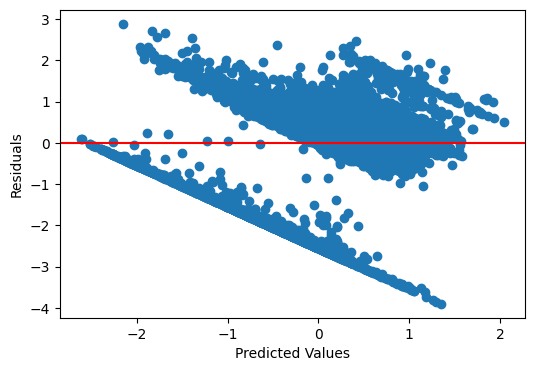

In [32]:
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data, epochs = 100, validation_data=(X_val_noisy, y_val_reg), verbose=0, callbacks=[early_stopping])
#history = ff_model.fit(X_low_vis_train, y_low_vis_train_scaled, epochs = 50, validation_data=(X_low_vis_val, y_low_vis_val_scaled))


# y_pred = ff_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# residuals = y_test - y_pred
# print(f'Mean squared error: {mse}')

y_pred = ff_model.predict(X_test_noisy)
#mse = mean_squared_error(y_low_vis_test_scaled, y_pred)
mse = mean_squared_error(y_test_reg, y_pred)

residuals = y_test_reg - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
#plt.scatter(y_low_vis_test_scaled, y_pred)
plt.scatter(y_test_reg, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

QRNN

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,793 (57.79 KB)

 Trainable params: 14,793 (57.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.3482 - val_loss: 0.2147
Epoch 2/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2183 - val_loss: 0.2114
Epoch 3/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2141 - val_loss: 0.2103
Epoch 4/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2130 - val_loss: 0.2091
Epoch 5/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2125 - val_loss: 0.2080
Epoch 6/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2127 - val_loss: 0.2070
Epoch 7/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2114 - val_loss: 0.2090
Epoch 8/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2115 - val_loss: 0.2072
Epoch 9/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.2099 - val_loss: 0.2071
Epoch 10/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2098 - val_loss: 0.2042
Epoch 11/40
5695/5695 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2099 - val_loss: 0.2034
Epoch 12/40
56

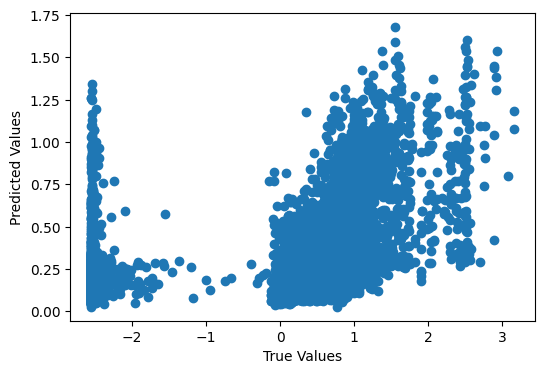

ValueError: x and y must be the same size

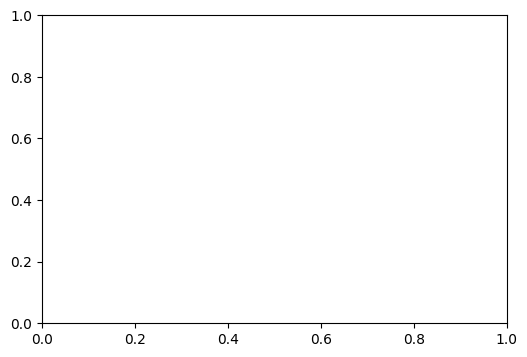

In [33]:
from qrnn import get_model, qloss
from keras.callbacks import *
import numpy as np


# Parameters
input_dim = len(features_i)
num_hidden_layers = 4
num_units = [64, 64, 64, 64]
act = ['relu', 'relu', 'relu', 'relu']
dropout = [0.1, 0.1, 0.1, 0.1]
gauss_std = [0.0, 0.0, 0.0, 0.0]
num_quantiles = 9

# Get model
model = get_model(input_dim, num_units, act, dropout, gauss_std, num_hidden_layers, num_quantiles)
print(model.summary())

# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss=lambda y_t, y_p: qloss(y_true=y_t, y_pred=y_p, n_q=num_quantiles), 
              optimizer='adam')
model.fit(x=X_train_noisy, y=y_train_reg, 
          epochs=40, 
          validation_split=0.1, 
          batch_size=64, 
          shuffle=True, 
          callbacks=[early_stopping]
         )

y_pred = model.predict(X_test_noisy)

mid_quantile = y_pred[:,4]
residuals = y_test_reg - mid_quantile 


print(mean_squared_error(y_test_reg, y_pred[:,4]))

# Scatter Plot
plt.figure(figsize=(6, 4))
#plt.scatter(y_low_vis_test_scaled, y_pred)
plt.scatter(y_test_reg, mid_quantile)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()